
# Assignment-9: Apply Random Forest On Amazon Fine Food Reviews DataSet 

## Introduction 

(i).A random forest consists of multiple random decision trees. Two types of randomnesses are built into the trees. First, each tree is built on a random sample from the original data. Second, at each tree node, a subset of features are randomly selected to generate the best split.

## Objective

To Predict the Polarity of Amazon Fine Food Review Using Random Forest Algorithm.

## Importing All Required Library

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors


import pickle


from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Importing Amazon Fine Food Review  Dataset

In [2]:
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from Reviews where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [3]:
# Printing some data of DataFrame

Data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

## Information About DataSet

In [4]:
print("\nNumber of Reviews: ",Data["Text"].count())
print("\nNumber of Users: ",len(Data["UserId"].unique())) # Unique returns 1-D array of unique values of DataFrame.
print("\nNumber of Products: ",len(Data["ProductId"].unique()))
print("\nShape of Data: ", Data.shape)
print("\nColumn Name of DataSet : ",Data.columns)
print("\n\nNumber of Attributes/Columns in data: 12") 
print("\nNumber of Positive Reviews : ", Data['Score'].value_counts()[1])
print("\nNumber of Negative Reviews : ", Data['Score'].value_counts()[0])


Number of Reviews:  364171

Number of Users:  243414

Number of Products:  65442

Shape of Data:  (364171, 12)

Column Name of DataSet :  Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')


Number of Attributes/Columns in data: 12

Number of Positive Reviews :  307061

Number of Negative Reviews :  57110


In [5]:
print("\nNumber of Reviews: ",Data["Text"].count())


Number of Reviews:  364171


## Attribute Information About DataSet

1.Id - A unique value starts from 1



2.ProductId - A unique identifier for the product



3.UserId - A unqiue identifier for the user



4.ProfileName - Name of user profile 



5.HelpfulnessNumerator - Number of users who found the review helpful



6.HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not



7.Score - Rating 0 or 1



8.Time - Timestamp for the review



9.Summary - Brief summary of the review



10.Text - Text of the review



11.Cleaned Text - Text that only alphabets

In [6]:
# Sorting on the basis of Time Parameter
Data.sort_values('Time',inplace=True)

In [7]:
Data=Data.head(100000)

In [8]:
Y = Data['Score']
X = Data['CleanedText']

## Splitting DataSet into Train and Test Data

In [9]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33,shuffle=False) # this is random splitting

print("Shape of Train and Test Dataset for 100k points")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

Shape of Train and Test Dataset for 100k points
(67000,) (67000,)
(33000,) (33000,)


## Defining Some Function

###  Train Data Confusion Matrix Plot

In [10]:
def trainconfusionmatrix(model,X_train,y_train):
    print("Confusion Matrix for Train set")
    cm=confusion_matrix(y_train, model.predict(X_train))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Train Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Test Data Confusion Matrix Plot

In [11]:
def testconfusionmatrix(model,X_test,y_test):
    print("Confusion Matrix for Test set")
    cm=confusion_matrix(y_test, model.predict(X_test))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Test Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### ROC-AUC Curve 

In [12]:
def plot_auc_roc(model,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train,model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("Hyperameter (C)")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

### GridSearchCV

In [23]:
def Grid_SearchCV(X_train,Y_train):
    
    param_grid= {'max_depth':[1,5,10,50,100,500,1000],
                  'n_estimators' :[5,10,20,50,100]
                }
    tscv = TimeSeriesSplit(n_splits=10)
    clf = RandomForestClassifier(class_weight='balanced')
    gsv=GridSearchCV(clf,param_grid, scoring = 'roc_auc', cv=tscv,n_jobs=-1,pre_dispatch=2)
    gsv.fit(X_train,Y_train)
    
    return gsv

### Train Auc Heatmap

In [26]:
def Train_Auc_Heatmap(gsv):
    results = gsv.cv_results_
    train = np.array(results['mean_train_score'])
    train = train.reshape(7,5)
    sns.heatmap(train,annot =True,yticklabels = [1,5,10,50,100,500,1000],xticklabels =[5,10,20,50,100],linewidths=.5,cmap="YlGnBu" )
    

### Test Auc Heatmap

In [27]:
def Cv_Auc_Heatmap(gsv):
    results = gsv.cv_results_
    cv = np.array(results['mean_test_score'])
    cv = cv.reshape(7,5)
    sns.heatmap(cv,annot =True,yticklabels = [1,5,10,50,100,500,1000],xticklabels =[5,10,20,50,100],linewidths=.5 ,cmap= 'YlGnBu' )

## Bags of Words Vectorizer

In [17]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_train_bow=preprocessing.normalize(X_train_bow)

X_test_bow = vectorizer.transform(X_test)
X_test_bow=preprocessing.normalize(X_test_bow)

print("Shape of Train and Test Data After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_test_bow.shape, Y_test.shape)

Shape of Train and Test Data After vectorizations
(67000, 30737) (67000,)
(33000, 30737) (33000,)


### Finding the best value Of hyperparameter

In [24]:
gsv=Grid_SearchCV(X_train_bow,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'max_depth': 500, 'n_estimators': 100}
Best Accuracy: 90.96%


### Train Auc HeatMap

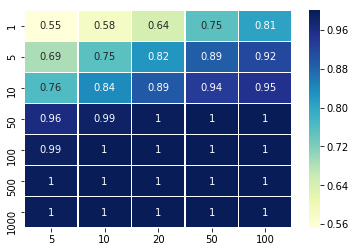

In [28]:
Train_Auc_Heatmap(gsv)

### Test Auc Heatmap

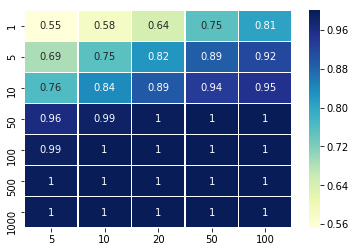

In [29]:
Train_Auc_Heatmap(gsv)

### Training the model

In [30]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
n_estimator =Best_Param['n_estimators']

Model_Bow=RandomForestClassifier(max_depth=depth,n_estimators=n_estimator,class_weight="balanced")
Model_Bow.fit(X_train_bow,Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=500, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [44]:
from sklearn.externals import joblib 
joblib.dump(Model_Bow,"BOW_Model.pkl")

['BOW_Model.pkl']

In [18]:
from sklearn.externals import joblib
Model_Bow=joblib.load("BOW_Model.pkl")

### Evaluating the performance of model

Confusion Matrix for Train set


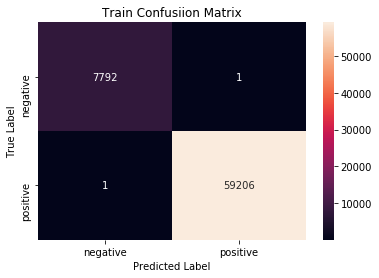

In [31]:
trainconfusionmatrix(Model_Bow,X_train_bow,Y_train)

Confusion Matrix for Test set


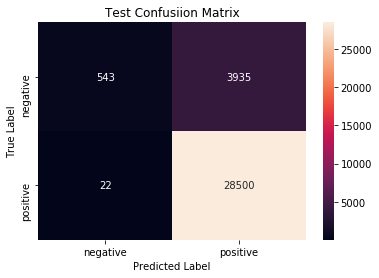

In [32]:
testconfusionmatrix(Model_Bow,X_test_bow,Y_test)

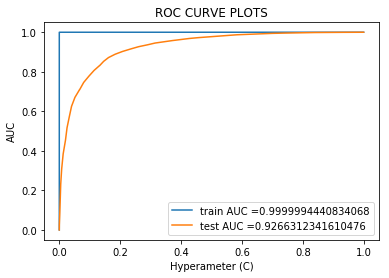

In [34]:
plot_auc_roc(Model_Bow,X_train_bow,X_test_bow,Y_train,Y_test)

In [35]:
print("Classification Report: \n")
y_pred=Model_Bow.predict(X_test_bow)

print(classification_report(Y_test, y_pred))


Classification Report: 

              precision    recall  f1-score   support

           0       0.96      0.12      0.22      4478
           1       0.88      1.00      0.94     28522

   micro avg       0.88      0.88      0.88     33000
   macro avg       0.92      0.56      0.58     33000
weighted avg       0.89      0.88      0.84     33000



### Important Feature

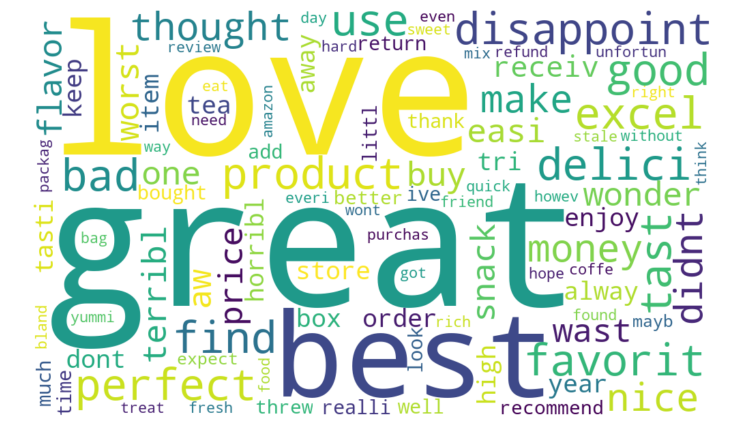

In [39]:
from wordcloud import WordCloud, STOPWORDS

features =vectorizer.get_feature_names()
coef = Model_Bow.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
#plt.title("Top 100 most important features\n")
plt.tight_layout(pad = 0) 
  
plt.show()

## TF-IDF Vectorizer

In [40]:
vectorizer_tfidf=TfidfVectorizer()
vectorizer_tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [41]:
X_Train_Tfidf=vectorizer_tfidf.transform(X_train)
X_Train_Tfidf=preprocessing.normalize(X_Train_Tfidf)

X_Test_Tfidf=vectorizer_tfidf.transform(X_test)
X_Test_Tfidf=preprocessing.normalize(X_Test_Tfidf)

In [42]:
print("Shape of Train and Test Data After vectorizations")
print(X_Train_Tfidf.shape, Y_train.shape)
print(X_Test_Tfidf.shape, Y_test.shape)

Shape of Train and Test Data After vectorizations
(67000, 30737) (67000,)
(33000, 30737) (33000,)


### Finding the best value Of hyperparameter

In [43]:
gsv=Grid_SearchCV(X_Train_Tfidf,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'max_depth': 1000, 'n_estimators': 100}
Best Accuracy: 90.99%


### Train Auc HeatMap

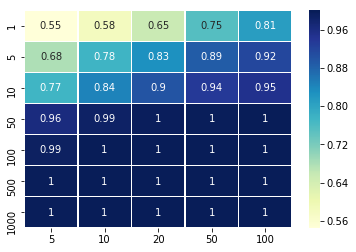

In [44]:
Train_Auc_Heatmap(gsv)

### Test Auc Heatmap

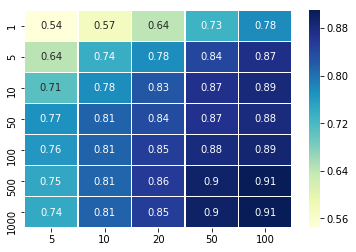

In [45]:
Cv_Auc_Heatmap(gsv)

### Training the model

In [47]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
n_estimator =Best_Param['n_estimators']

Model_Tfidf=RandomForestClassifier(max_depth=depth,n_estimators=n_estimator,class_weight="balanced")
Model_Tfidf.fit(X_Train_Tfidf,Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=1000, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


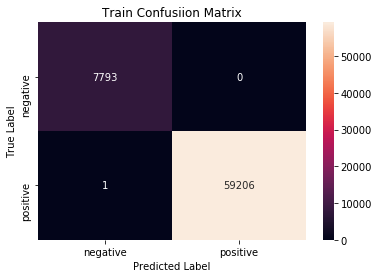

In [48]:
trainconfusionmatrix(Model_Tfidf,X_Train_Tfidf,Y_train)

Confusion Matrix for Test set


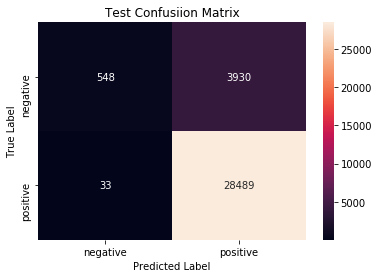

In [49]:
testconfusionmatrix(Model_Tfidf,X_Test_Tfidf,Y_test)

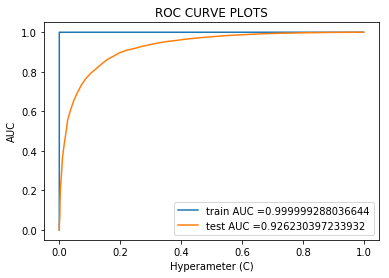

In [50]:
plot_auc_roc(Model_Tfidf,X_Train_Tfidf,X_Test_Tfidf,Y_train,Y_test)

In [51]:
print("Classification Report: \n")
y_pred=Model_Tfidf.predict(X_Test_Tfidf)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.94      0.12      0.22      4478
           1       0.88      1.00      0.93     28522

   micro avg       0.88      0.88      0.88     33000
   macro avg       0.91      0.56      0.58     33000
weighted avg       0.89      0.88      0.84     33000



### Important Features

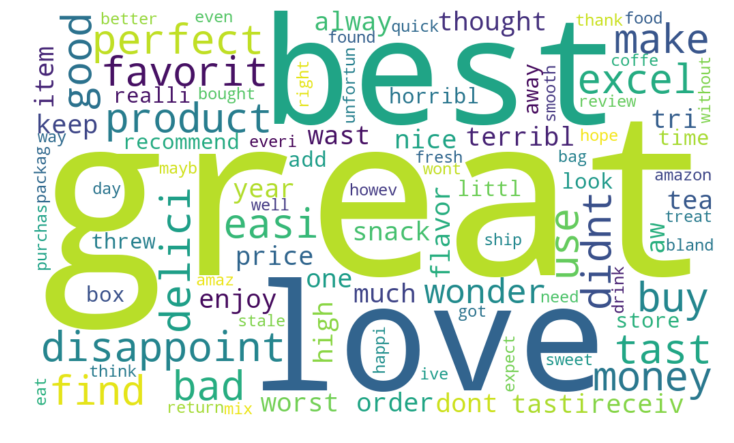

In [53]:
from wordcloud import WordCloud, STOPWORDS

features =vectorizer.get_feature_names()
coef = Model_Tfidf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
#plt.title("Top 100 most important features\n")
plt.tight_layout(pad = 0) 
  
plt.show()

## Word To Vector

In [54]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in X_train:
    list_of_Train_sent.append(sent.split())
    
for sent in X_test:
    list_of_Test_sent.append(sent.split())

In [55]:
model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4)

## Average Word To Vector

In [56]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [57]:
import numpy as np

Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)    

In [58]:
print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (33000, 50)


In [59]:
X_Train_Awv=Train_vectors
X_Test_Awv=Test_vectors

In [60]:
print(X_Train_Awv.shape, Y_train.shape)
print(X_Test_Awv.shape, Y_test.shape)

(67000, 50) (67000,)
(33000, 50) (33000,)


### Finding the best value Of hyperparameter

In [61]:
gsv=Grid_SearchCV(X_Train_Awv,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'max_depth': 50, 'n_estimators': 100}
Best Accuracy: 87.15%


### Train Auc Heatmap

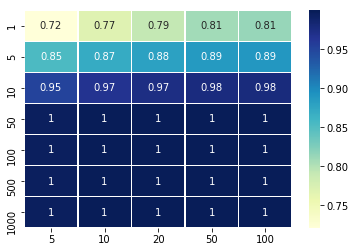

In [62]:
Train_Auc_Heatmap(gsv)

### Test Auc Heatmap

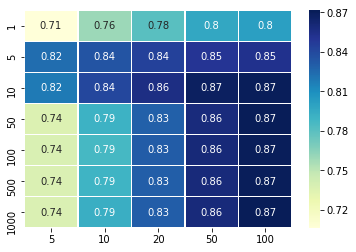

In [63]:
Cv_Auc_Heatmap(gsv)

### Training Model 

In [64]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
n_estimator =Best_Param['n_estimators']

Model_Awv=RandomForestClassifier(max_depth=depth,n_estimators=n_estimator,class_weight="balanced")
Model_Awv.fit(X_Train_Awv,Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


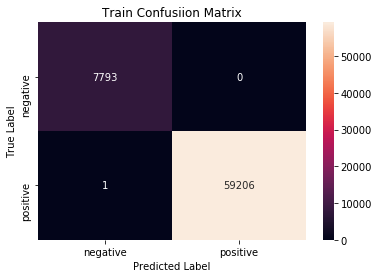

In [65]:
trainconfusionmatrix(Model_Awv,X_Train_Awv,Y_train)

Confusion Matrix for Train set


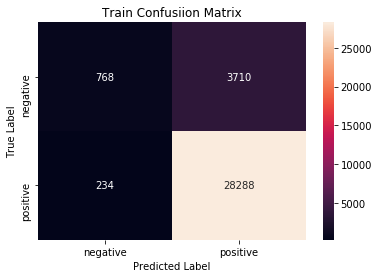

In [66]:
trainconfusionmatrix(Model_Awv,X_Test_Awv,Y_test)

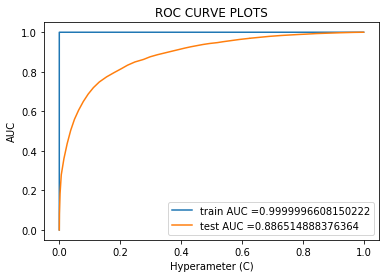

In [69]:
plot_auc_roc(Model_Awv,X_Train_Awv,X_Test_Awv,Y_train,Y_test)

In [68]:
print("Classification Report: \n")
y_pred=Model_Awv.predict(X_Test_Awv)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.77      0.17      0.28      4478
           1       0.88      0.99      0.93     28522

   micro avg       0.88      0.88      0.88     33000
   macro avg       0.83      0.58      0.61     33000
weighted avg       0.87      0.88      0.85     33000



## TF-IDF Word To Vector

In [70]:
TFIDF_Feature=vectorizer_tfidf.get_feature_names()
print(len(TFIDF_Feature))
print(TFIDF_Feature[0:20])

30737
['aaa', 'aaaaaaaaagghh', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaah', 'aaah', 'aachen', 'aad', 'aadp', 'aafco', 'aagh', 'aah', 'aahh', 'aand', 'aardvark', 'ab', 'aback', 'abandon', 'abaolut', 'abattoir']


In [71]:
w2v_words = list(model.wv.vocab)
print("Number of words that occured minimum 5 times ",len(w2v_words))
print("Sample words ", w2v_words[0:50])

Number of words that occured minimum 5 times  10488
Sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool']


In [72]:
from tqdm import tqdm
Train_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Train_sent):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            if word in TFIDF_Feature and word in w2v_words:
                
                w2v_vec=model.wv[word]
                tfidf_vec=X_Train_Tfidf[row,TFIDF_Feature.index(word)]
                sent_vec+=(w2v_vec*tfidf_vec)
                weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors.append(sent_vec) 
    row+=1

100%|██████████████████████████████████| 67000/67000 [1:00:12<00:00, 18.55it/s]


In [73]:
Test_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Test_sent):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
             if word in TFIDF_Feature and word in w2v_words:
                    
                w2v_vec=model.wv[word]
                tfidf_vec=X_Test_Tfidf(row,TFIDF_Feature.index(word))
                sent_vec+=(w2v_vec*tfidf_vec)
                weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors.append(sent_vec)    
    row+=1

100%|████████████████████████████████████| 33000/33000 [23:28<00:00, 23.42it/s]


In [74]:
Train_TFIDF_W2V_Vectors = np.nan_to_num(Train_TFIDF_W2V_Vectors)
Test_TFIDF_W2V_Vectors = np.nan_to_num(Test_TFIDF_W2V_Vectors)

In [75]:
X_Train_TfidfW2v=Train_TFIDF_W2V_Vectors
X_Test_TfidfW2v=Test_TFIDF_W2V_Vectors

In [76]:
print(X_Train_TfidfW2v.shape, Y_train.shape)
print(X_Test_TfidfW2v.shape, Y_test.shape)

(67000, 50) (67000,)
(33000, 50) (33000,)


### Finding the best value Of hyperparameter  

In [77]:
gsv=Grid_SearchCV(X_Train_TfidfW2v,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'max_depth': 500, 'n_estimators': 100}
Best Accuracy: 84.17%


### Train Auc Heatmap

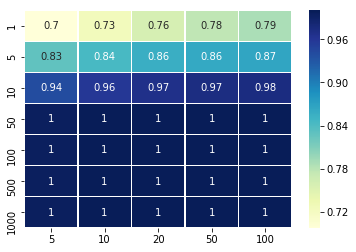

In [78]:
Train_Auc_Heatmap(gsv)

### Test Auc Heatmap

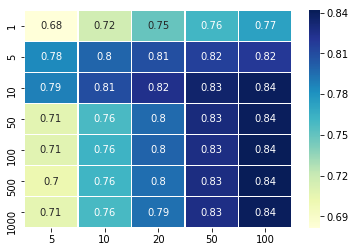

In [79]:
Cv_Auc_Heatmap(gsv)

### Training Model

In [80]:
Best_Param=gsv.best_params_
n_estimator =Best_Param['n_estimators']

Model_TfidfW2v=RandomForestClassifier(max_depth=depth,n_estimators=n_estimator,class_weight="balanced")
Model_TfidfW2v.fit(X_Train_TfidfW2v,Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


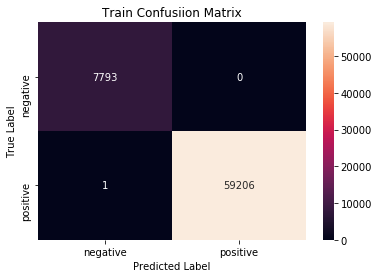

In [81]:
trainconfusionmatrix(Model_TfidfW2v,X_Train_TfidfW2v,Y_train)

Confusion Matrix for Test set


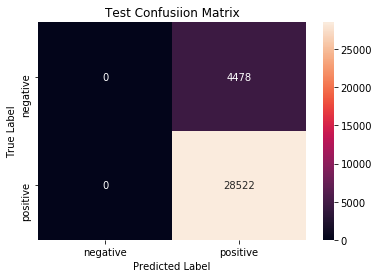

In [82]:
testconfusionmatrix(Model_TfidfW2v,X_Test_TfidfW2v,Y_test)

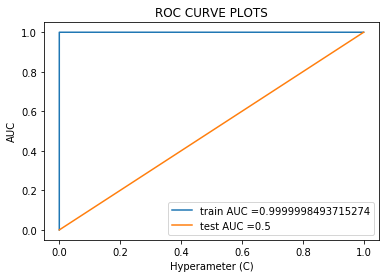

In [83]:
plot_auc_roc(Model_TfidfW2v,X_Train_TfidfW2v,X_Test_TfidfW2v,Y_train,Y_test)

In [84]:
print("Classification Report: \n")
y_pred=Model_TfidfW2v.predict(X_Test_TfidfW2v)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4478
           1       0.86      1.00      0.93     28522

   micro avg       0.86      0.86      0.86     33000
   macro avg       0.43      0.50      0.46     33000
weighted avg       0.75      0.86      0.80     33000



### Conclusion

1. Report on different vectorizer method

In [2]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter(max_depth)","Hyperparameter(n_estimator)","Train AUC","Test AUC","F1-Score"]

x.add_row(["BOW",500,100,0.99,0.92,0.84])
x.add_row(["TF-IDF",1000,100,0.99,0.92,0.84])
x.add_row(["Avg W2V",50,100,0.99,0.88,0.85])
x.add_row(["TF-IDF W2V",500,100,0.99,0.50,0.80])

print(x)

+------------+---------------------------+-----------------------------+-----------+----------+----------+
| Vectorizer | Hyperparameter(max_depth) | Hyperparameter(n_estimator) | Train AUC | Test AUC | F1-Score |
+------------+---------------------------+-----------------------------+-----------+----------+----------+
|    BOW     |            500            |             100             |    0.99   |   0.92   |   0.84   |
|   TF-IDF   |            1000           |             100             |    0.99   |   0.92   |   0.84   |
|  Avg W2V   |             50            |             100             |    0.99   |   0.88   |   0.85   |
| TF-IDF W2V |            500            |             100             |    0.99   |   0.5    |   0.8    |
+------------+---------------------------+-----------------------------+-----------+----------+----------+


2. I have taken two hyper-parameter to train model that is max_depth and n_estimator.

3. In BOW and TF-IDF , model is performing well .

4. Model is Overfit in case of TF-IDF W2v .